#### Student informations (Max. 2 students) should be written in this cell (Student ID, Student Name).

Student 1: Mustafa Kırcı 150200096

Student 2: Matay Aydın   150200075

# HOMEWORK 2:   Gradient Descent, Stocahtic Gradient Descent, Data Normalization and Cross Validation for Regression Training and Testing

In Homework 1, we trained various Linear and Polynomial regression models by using direct and iterative optimization methods. However, testing was not included. In this homework you are assigned training and _testing_ various regression models, and building complete learning pipelines by implementing data normalization and cross-validation in your solutions. 

Your homework consists of a total of 5 problems. Please read this notebook carefully to ensure that you provide all the required solutions to the problems. (For your questions, please email: ergunesr@itu.edu.tr. Note: I will only guide you to the solutions and will not directly check your codes/answers or provide the answers.)

# 1.1 Training and Testing a Linear Regression Model with Gradient Descent and Data Normalization

In the following problem you are provided with a synthetic dataset consisting 500 samples and one feature dimension. You are expected to complete the **minMaxScaler** inside the **data_utils.py**, **GradientDescent** in **linearRegression.py** as instructed, train a linear regression model with the training split of your data, and make predictions. Please read carefully the cells in this notebook and make sure you implement and report every result required. 

Let's briefly recall **Linear Regression** from Homework 1:

Suppose we have $p$ input-output observation pairs that we want to regress:
<div style="text-align:center">
${ \{ (\mathbf{x_1},y_1), (\mathbf{x_2},y_2), ... ,(\mathbf{x_P}, y_P) \} } $
</div> 
where $\mathbf{x_p}$ and $y_p$ denote the $p$th input and output respectively. In 2-dimensional space, where we have a scalar input and output, linear regression problem is a line fitting problem. As an example of a problem in which regression analysis may be
helpful, suppose input represents living areas and output represents prices of houses in Istanbul. Given this data, how can we learn to predict the prices of other houses in Istanbul, as a function of the size of their living areas? 

Generally, each input will be a column vector of length $N$, and we will denote this as $\mathbf{x_p}$. With input dimension $N$, linear regression problem is fitting a hyperplane to a scatter of points in $N+1$ dimensional space. 

In the case of scalar input, fitting a line to data requires determining a slope $w$ and bias (or $y$-intercept) $b$ so that we approaximate linear relationship holds between the input/output data:
<div style="text-align:center">
    $b + x_p w \approx y_p, $ 

</div> 

where             $p=1,...,P.$

When the input dimension is larger than 1, $N>1$, then we have a bias and $N$ associated weights.
<div style="text-align:center">
$\mathbf{w} = \begin{bmatrix}
w_1 \\
w_2 \\
\vdots \\
w_{N}
\end{bmatrix}$
</div> 
Input variables (the elements of an input vector $\mathbf{x_p}$) are also called input features.  We will use $x_{i,p}$ to denote the input features so that an input vector is:

<div style="text-align:center">
$\mathbf{x} = \begin{bmatrix}
x_{1,p} \\
x_{2,p} \\
\vdots \\
x_{N,p}
\end{bmatrix}$
</div> 

The goal of linear regression is to estimate the bias and weights that minimize the sum of squared differences between the output values $y_p$ and the values predicted by the model $\hat{y}_p$.

We will use these notations for mathematical convenience;
 <div style="text-align:center">
$\mathbf{\widetilde{x}_p} = \begin{bmatrix}
1 \\
\mathbf{x_p} \\
\end{bmatrix}$  

 </div> 

<div style="text-align:center">
$\mathbf{\widetilde{w}} = \begin{bmatrix}
b \\
\mathbf{w} \\
\end{bmatrix}$  

</div> 

## Installation 
To start your homework, you need to install requirements. We recommend that you use conda environment for this homework. 

1. conda create -n ldhw2 python=3.8 numpy=1.23.5 matplotlib
2. conda activate ldhw2
3. conda install -c conda-forge notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from data_utils import generate_data
# xData and yData constitutes your training set.

x_train, y_train, x_test, y_test = generate_data()

The **transform** and **inverse_transform** methods are part of the **MinMaxScaler** class, which is commonly used for feature scaling and normalization. Feature scaling is important in data preprocessing to ensure that features with larger values do not dominate the model training process. The transform method scales the input data to a desired range, while the **inverse_transform** method can be used to reverse this scaling operation. By implementing these methods in the data_utils.py file, we can ensure that the input data is properly scaled and balanced, which can improve the performance of the regressors.

In [3]:
from data_utils import MinMaxScaler
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(x_train)


# Transform x_train and x_test
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


# Do the same for target variables
scaler_y = MinMaxScaler(y_train)


# Transform x_train and x_test
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [4]:
def plotCostCurves(title):
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title(title)
    plt.show()

def _findOptimumInitWeightsDetailed(x_range, y_range, x_train, y_train, lr, max_iterations, model):
    """
    Find the best initialization for the weights by trying different initializations.
    The range is iterated by x_range and y_range one by one.
    """

    if(not callable(model)):
        raise ValueError("model must be a callable function or class")

    best_cost = float('inf')
    best_weights = None
    
    
    # Iterate through all possible combinations of weight values
    for w1 in x_range:
        for w2 in y_range:
            weights = np.array([[w1], [w2]])
            
            # Train the model with the current set of weights
            model_instance = model(x_train, y_train, weights, lr, max_iterations)
            model_instance.fit(lr, max_iterations)
            
            # Evaluate the performance of the model
            cost = model_instance.cost_history[-1]
            
            # Update the best weights if the current set of weights performs better
            if cost < best_cost:
                best_cost = cost
                best_weights = weights
                plt.plot(model_instance.cost_history, label=weights)

    
    
    return best_weights, best_cost

def findOptimumInitWeights(min, max, x_train, y_train, lr, max_iterations, model, sensitivity=50):
    """
    Finds the best initialization for the weights by trying different initializations.
    First a coarse search is done to find the best range of weights, then a finer search is done within that range.
    
    ! Number of times model runs increases as sensitivity decreases.
    """

    if(not callable(model)):
        raise ValueError("model must be a callable function or class")

    best_cost = float('inf')
    best_weights = None
    
    # Define the grid of possible values for each weight parameter
    weight_range = np.linspace(min, max, int((max - min) / sensitivity) + 1)
    
    # Iterate through all possible combinations of weight values
    for w1 in weight_range:
        for w2 in weight_range:
            weights = np.array([[w1], [w2]])
            
            # Train the model with the current set of weights
            model_instance = model(x_train, y_train, weights, lr, max_iterations)
            model_instance.fit(lr, max_iterations)
            
            # Evaluate the performance of the model
            cost = model_instance.cost_history[-1]
            
            # Update the best weights if the current set of weights performs better
            if cost < best_cost:
                best_cost = cost
                best_weights = weights
                plt.plot(model_instance.cost_history, label=weights)
    x_min = int(best_weights[0] - (max - min) / sensitivity)
    x_max = int(best_weights[0] + (max - min) / sensitivity)
    x_range = np.linspace(x_min, x_max, x_max-x_min)

    y_min = int(best_weights[1] - (max - min) / sensitivity)
    y_max = int(best_weights[1] + (max - min) / sensitivity)
    y_range = np.linspace(y_min, y_max, y_max-y_min)

    
    return _findOptimumInitWeightsDetailed(x_range, y_range, x_train, y_train, lr, max_iterations, model)


Now, you need to create two model objects to train one on unnormalized and the other on normalized data. Learning rate is set to 0.1. You only need to implement weight initialization search, and plot your cost curves. (One for each model.)

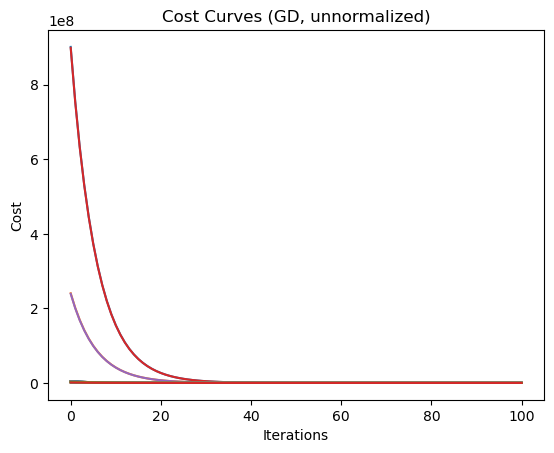

Best initialization weights for unnormalized data:  [[-46.        ]
 [ -0.57142857]]
Cost:  45916.79025507568


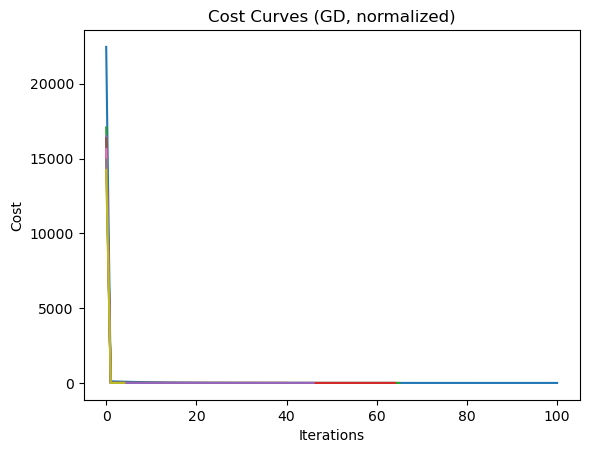

Best initialization weights for normalized data:  [[-96.        ]
 [-47.14285714]]
Cost:  0.0086984977374043
[14239.011844333118, 2.319651460735743, 0.00909689119433238, 0.008709696859565583, 0.0086984977374043]


In [5]:
from linearRegression import gradientDescent
lr = 0.000001
max_iterations = 100

###### TO DO: try different initializations and plot the cost curves, pick the best initialization accordingly.#####
####################################################################################################################
w, c = findOptimumInitWeights(-100, 100, x_train, y_train, lr, max_iterations, gradientDescent)
plotCostCurves("Cost Curves (GD, unnormalized)")
print("Best initialization weights for unnormalized data: ", w)
print("Cost: ", c)
model_unnormalized = gradientDescent(x_train, y_train, w, lr, max_iterations)
# train the model by calling fit() function
model_unnormalized.fit(lr, 100)

###### TO DO: try different initializations and plot the cost curves, pick the best initialization accordingly.#####
####################################################################################################################
lr = 0.8
w,c = findOptimumInitWeights(-100, 100, x_train_scaled, y_train_scaled, lr, max_iterations, gradientDescent)
plotCostCurves("Cost Curves (GD, normalized)")
print("Best initialization weights for normalized data: ", w)
print("Cost: ", c)
# Constructing model to train on normalized data. 
model_normalized = gradientDescent(x_train_scaled, y_train_scaled, w, lr, max_iterations)
# train the model by calling fit() function
model_normalized.fit(lr, 400)
print(model_normalized.cost_history)

After finding the best weight initialization for both models you please compare the training cost plots and testing error (RMSE) results of **model_unnormalized** and **model_normalized**.

You may use **predict()** method to get predicted results of **x_test**. After that, you need to use **inverse_transform** method of your **minMaxScaler** class. 

In [6]:
# Predict unnormalized test data
x_biased = np.c_[np.ones((x_test.shape[0], 1)), x_test] # Add bias term
y_unnorm_predict = model_unnormalized.predict(x_biased)

# Predict normalized test data
x_scaled_biased = np.c_[np.ones((x_test_scaled.shape[0], 1)), x_test_scaled] # Add bias term
y_norm_predict = model_normalized.predict(x_scaled_biased)

Now, you may run the following cell to plot the training data (in blue) and the predicted test values (in red).

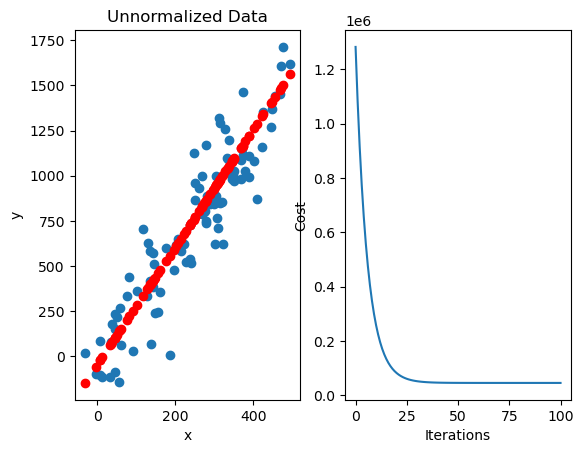

In [7]:
plt.subplot(1, 2, 1)
plt.scatter(x_test, y_test)
plt.scatter(x_test, y_unnorm_predict, color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Unnormalized Data')
plt.subplot(1, 2, 2)
plt.plot(model_unnormalized.cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')

plt.show()

Before plotting the points for the normalized case, we need to transfer the normalized points to the original data space by calling **inverse_transform** method of the **minMaxScaler**.

In [8]:
y_norm_inv = scaler_y.inverse_transform(y_norm_predict)

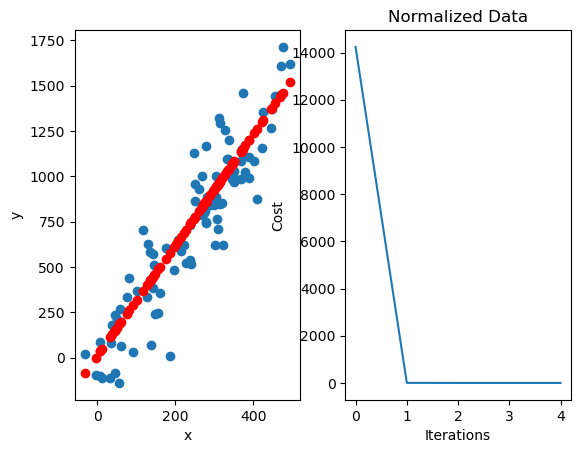

In [9]:
plt.subplot(1, 2, 1)
plt.scatter(x_test, y_test)
plt.scatter(x_test, y_norm_inv, color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.subplot(1, 2, 2)
plt.plot(model_normalized.cost_history)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Normalized Data')

plt.show()

Now, let's compare the **Root Mean Squared Errors** of both methods. 

In [10]:
rmse_unnorm = np.sqrt(np.sum(np.square(y_test - y_unnorm_predict)))/y_test.shape[0]

rmse_norm = np.sqrt(np.sum(np.square(y_test - y_norm_inv)))/y_test.shape[0]

print("RMSE for unnormalized training:", rmse_unnorm)
print("RMSE for normalized training:", rmse_norm)

RMSE for unnormalized training: 17.2046933362255
RMSE for normalized training: 17.258939042528745


Depending on the type of data you have, normalized training can show its benefits significantly in your model's prediction results. 

# 1.2 Linear Regression with Gradient Descent, Stochastic Gradient Descent, and Data Scaling

In the previous problem, you were assigned to find solutions to mean squared error linear regressor with gradient descent algorithm. In this question you are asked to implement **Stochastic Gradient Descent (SGD)**. SGD is a variant of gradient descent wherein we pick a sample $I_t$ uniformly at random in $\{1,...,p\}$ and update the weights as follows:

\begin{align*}
w_{i}^{t+1} &= w_{i}^{t} - \alpha \frac{\partial g(\mathbf{\widetilde{w}}^{t})}{\partial w_{i}^t} \text{ for all } i \\
b^{t+1} &= b^{t} - \alpha \frac{\partial g(\mathbf{\widetilde{w}}^t)}{\partial b^t}
\end{align*}

- $\mathbf{\widetilde{w}}^{t}$ represents the weight vector at time step $t$.
- $\alpha$ is the learning rate.
- $g(\mathbf{\widetilde{w}}^{t})$ is the loss function computed with $I_t$.
- $\frac{\delta g(\mathbf{\widetilde{w}}^{t})}{\delta \mathbf{\widetilde{w}}^{t}}$ denotes the gradient of the loss function with respect to the weights $\mathbf{\widetilde{w}}^{t}$.

### In this problem you are expected to implement SGD algorithm with Mean Squared Error cost and build a linear regression pipeline:

1) Implement **Stochastic Gradient Descent** algorithm for Mean Squared Error, complete the class **stochasticGradientDescent()** under **linearRegression.py**

2) Normalize your data with **minMaxScaler()**,

3) Construct two Linear Regression models by calling **GradientDescent()** and **stochasticGradientDescent()**,

4) Optimize the model parameters with Gradient Descent and Stochastic Gradient Descent. Implement hyperparameter search for weight initialization. Report your search results. Compare the performance of the models in terms of training cost convergence and testing RMSE.

5) Repeat 3 and 4 for the original **unnormalized** data, report your cost plots, and RMSEs.

You are required to report four final cost curves (except hyperparameter optimizations) and four RMSE scores, one for each case. Comment on your results in a cell below. You may use the same learning rate as problem 1.1 .

In [11]:
def plotFitAndCostCurves(cost_history, x_test, y_test, y_predict):
    
    plt.subplot(1, 2, 1)
    plt.scatter(x_test, y_test)
    plt.scatter(x_test, y_predict, color='red')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Data')
    plt.subplot(1, 2, 2)
    plt.plot(cost_history)
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title('Cost Curve')
    plt.show()


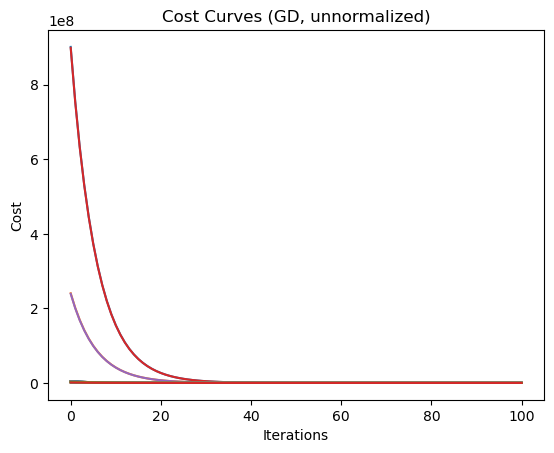

GD
Best initialization weights for unnormalized data:  [[-46.        ]
 [ -0.57142857]]
Cost:  45916.79025507568


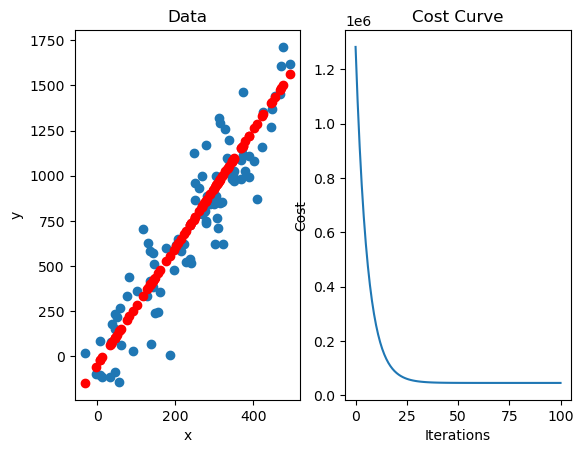

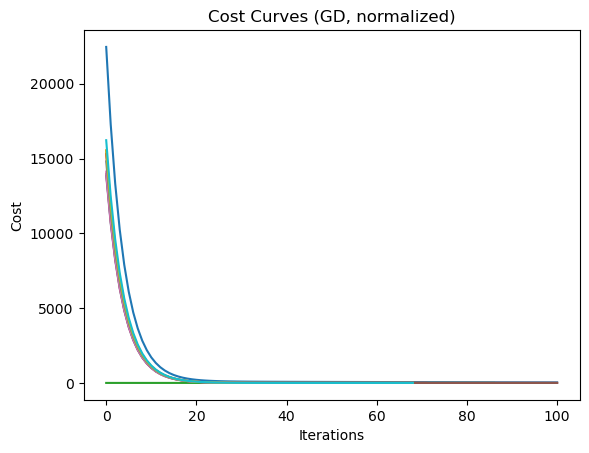

GD
Best initialization weights for normalized data:  [[102.85714286]
 [ 51.71428571]]
Cost:  0.009873560034344898


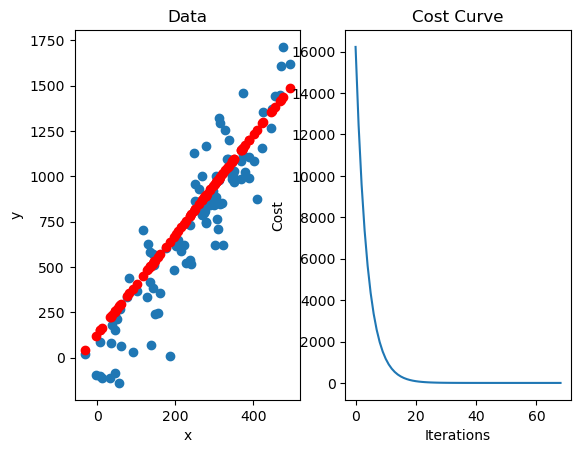

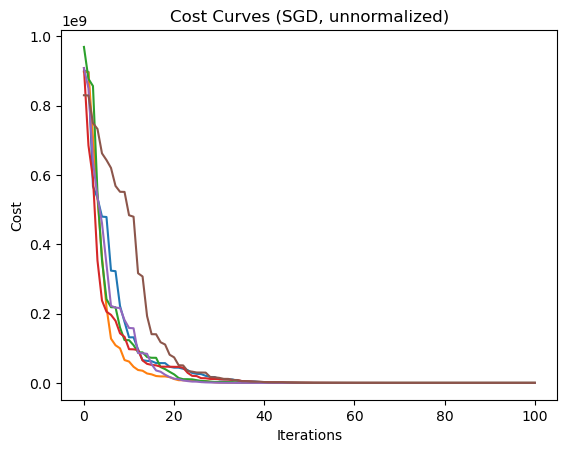

SGD
Best initialization weights for unnormalized data:  [[-49.42857143]
 [-96.        ]]
Cost:  45954.93528080215


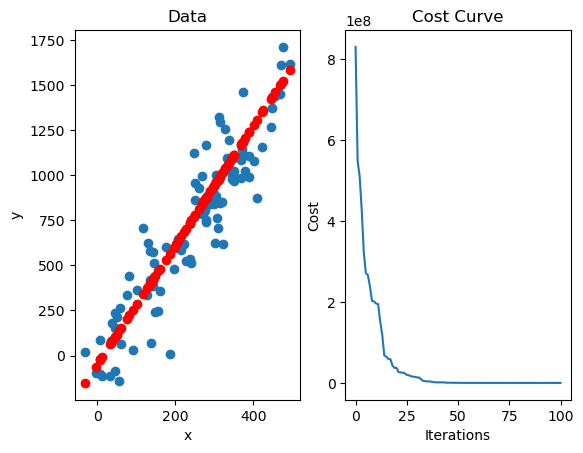

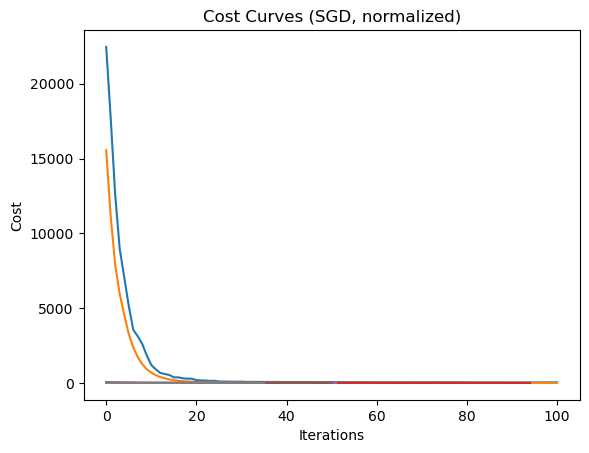

SGD
Best initialization weights for normalized data:  [[1.71428571]
 [1.71428571]]
Cost:  0.009048669071596755


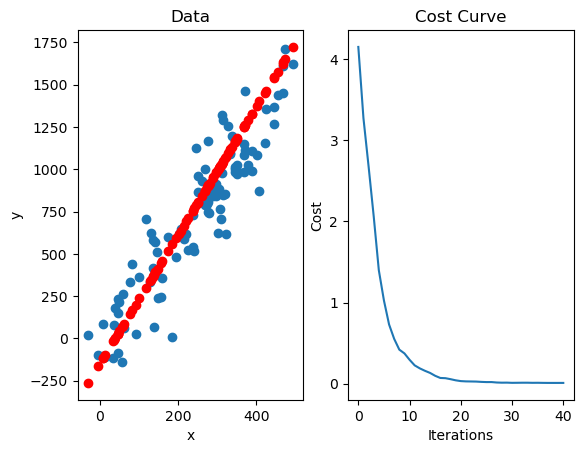

==============GD================
RMSE for unnormalized training: 17.2046933362255
RMSE for normalized training: 19.160081475916197
==============SGD================
RMSE for unnormalized training: 17.472435170937548
RMSE for normalized training: 19.721275397341167


In [12]:
##############################################################################
# TODO: Implement Stochastic Gradient Descent (SGD) algorithm in             #
# LinearRegression module. (For mean squared error cost)                     #
# Perform data scaling with MinMaxScaler                                     #
# Train the Linear Regression model with both Gradient Descent (with MSE     #
# and SGD                                                                    #
# Plot the training costs and test error.                                    #
# Repeat for the unnormalized data and compare the results.                  #
##############################################################################
from linearRegression import SGD

x_train, y_train, x_test, y_test = generate_data()

scaler_x = MinMaxScaler(x_train)
x_train_scaled = scaler_x.transform(x_train)
x_test_scaled = scaler_x.transform(x_test)

scaler_y = MinMaxScaler(y_train)
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

x_test_biased = np.c_[np.ones((x_test.shape[0], 1)), x_test]
x_test_scaled_biased = np.c_[np.ones((x_test_scaled.shape[0], 1)), x_test_scaled]

max_iterations = 100


# Find the best initialization weights for the unnormalized data GD:
print("====================================================================")
lr = 0.000001
w, c = findOptimumInitWeights(-100, 100, x_train, y_train, lr, max_iterations, gradientDescent)
plotCostCurves("Cost Curves (GD, unnormalized)")
print("GD")
print("Best initialization weights for unnormalized data: ", w)
print("Cost: ", c)
model_unnormalized = gradientDescent(x_train, y_train, w, lr, max_iterations)
model_unnormalized.fit(lr, max_iterations)

y_unnorm_predict = model_unnormalized.predict(x_test_biased)
plotFitAndCostCurves(model_unnormalized.cost_history, x_test, y_test, y_unnorm_predict) 
RMSE_GD_UNNORM = np.sqrt(np.sum(np.square(y_test - y_unnorm_predict)))/y_test.shape[0]

# Find the best initialization weights for the normalized data GD:
print("====================================================================")
lr = 0.1
w,c = findOptimumInitWeights(-100, 100, x_train_scaled, y_train_scaled, lr, max_iterations, gradientDescent)
plotCostCurves("Cost Curves (GD, normalized)")
print("GD")
print("Best initialization weights for normalized data: ", w)
print("Cost: ", c)
model_normalized = gradientDescent(x_train_scaled, y_train_scaled, w, lr, max_iterations)
model_normalized.fit(lr, max_iterations)

y_norm_predict = model_normalized.predict(x_test_scaled_biased)
y_norm_inv = scaler_y.inverse_transform(y_norm_predict)
plotFitAndCostCurves(model_normalized.cost_history, x_test, y_test, y_norm_inv)
RMSE_GD_NORM = np.sqrt(np.sum(np.square(y_test - y_norm_inv)))/y_test.shape[0]

# Find the best initialization weights for the unnormalized data SGD:
print("====================================================================")
lr = 0.000001
w, c = findOptimumInitWeights(-100, 100, x_train, y_train, lr, max_iterations, SGD)
plotCostCurves("Cost Curves (SGD, unnormalized)")
print("SGD")
print("Best initialization weights for unnormalized data: ", w)
print("Cost: ", c)
model_unnormalized = SGD(x_train, y_train, w, lr, max_iterations)
model_unnormalized.fit(lr, max_iterations)

y_unnorm_predict = model_unnormalized.predict(x_test_biased)
plotFitAndCostCurves(model_unnormalized.cost_history, x_test, y_test, y_unnorm_predict)
RMSE_SGD_UNNORM = np.sqrt(np.sum(np.square(y_test - y_unnorm_predict)))/y_test.shape[0]

# Find the best initialization weights for the normalized data SGD:
print("====================================================================")
lr = 0.1
w,c = findOptimumInitWeights(-100, 100, x_train_scaled, y_train_scaled, lr, max_iterations, SGD)
plotCostCurves("Cost Curves (SGD, normalized)")
print("SGD")
print("Best initialization weights for normalized data: ", w)
print("Cost: ", c)
model_normalized = SGD(x_train_scaled, y_train_scaled, w, lr, max_iterations)
model_normalized.fit(lr, max_iterations)

y_norm_predict = model_normalized.predict(x_test_scaled_biased)
y_norm_inv = scaler_y.inverse_transform(y_norm_predict)
plotFitAndCostCurves(model_normalized.cost_history, x_test, y_test, y_norm_inv)
RMSE_SGD_NORM = np.sqrt(np.sum(np.square(y_test - y_norm_inv)))/y_test.shape[0]

# Print errors
print("====================================================================")
print("==============GD================")
print("RMSE for unnormalized training:", RMSE_GD_UNNORM)
print("RMSE for normalized training:", RMSE_GD_NORM)

print("==============SGD================")
print("RMSE for unnormalized training:", RMSE_SGD_UNNORM)
print("RMSE for normalized training:", RMSE_SGD_NORM)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

# 1.3 Polynomial Regression with Gradient Descent and Stochastic Gradient Descent

You have been provided with a dataset (Q1_3.py) consisting of two dimension as features and one dimension for regression.  After generating the corresponding Vandermonde matrix for the problem, you are expected to train a $2$nd order polynomial model on the training data, and later test your models. Specifically, the assignment is to complete the following tasks:

1) By using the unnormalized data, train a polynomial regression model to find optimal weights $\mathbf{\widetilde{w}}^{*}$ by using Gradient Descent and Stochastic Gradient Descent. Explore how the choice of weight initializations in gradient descent and stochastic gradient descent affects the convergence and final weights. You may change the search space provided to you as you want. Test your model on the tesing data and report RMSE. 

2) Print and compare the weight vectors obtained by gradient descent and stochastic gradient descent. How close are the values in each dimension?

3) Normalize your data, repeat step 1 and 2. Compare the training cost curves and testing RMSE errors.

**Recall:**

Polynomial regression is an extension of linear regression designed to model more complex relationships between input features and the target variable. While linear regression assumes a straight-line relationship, polynomial regression introduces higher-degree terms to capture nonlinear patterns. Polynomials are widely used in situations where the response is curvilinear.

Suppose we have $P$ scalar input-output observation pairs:
<div style="text-align:center">
${ \{ (x_1,y_1), (x_1,y_2), ... ,(x_P, y_P) \} } $
</div>

The following model is a $d$-th order polynomial in one variable:
<div style="text-align:center">
$ y_p = b + w_1 x_1 + w_2 {x_p}^{2} + w_3 {x_p}^3 + ... + w_d {x_p}^d$
</div>

Similar to linear regression, one can fit the observation set to a polynomial model by using direct optimization with least squares method. Different from linear regression, one needs to create a special design matrix named Vandermonde matrix, $V$, for storing input values according to the polynomial expression. When $x_p$ is a scalar, we can construct $\mathbf{V}$ as follows:

<div style="text-align:center">
$ \mathbf{V} = \begin{bmatrix}
1 & x_1 & x_1^2 & \ldots & x_1^{d} \\
1 & x_2 & x_2^2 & \ldots & x_2^{d} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_P & x_P^2 & \ldots & x_P^{d}
\end{bmatrix} $
</div>
Suppose input is a 2 dimensional vector with independent features:

<div style="text-align:center">
$\mathbf{{x}_p} = \begin{bmatrix}
x_{1,p} \\
x_{2,p} \\
\end{bmatrix}$  
</div>

Then, the corresponding Vandermonde matrix is (for a degree $d$ polynomial model):

<div style="text-align:center">
$ \mathbf{V} = \begin{bmatrix}
1 & x_{1,1} & x_{2,1} & x_{1,1}^2 & x_{2,1}^2  & \ldots & x_{1,1}^{d} & x_{2,1}^{d} \\
1 & x_{1,2} & x_{2,2} & x_{1,2}^2  & x_{2,2}^2  & \ldots & x_{1,2}^{d} & x_{2,2}^{d} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots  & \vdots  \\
1 & x_{1,P} & x_{2,P} & x_{1,P}^2 & x_{2,P}^2  & \ldots & x_{1,P}^{d} & x_{2,P}^{d} \\
\end{bmatrix} $
</div>

**In this question, you may set learning rate to 0.009.**

In [13]:
import numpy as np

with open('Q1_3.npy', 'rb') as f:
    x_train = np.load(f)
    x_test = np.load(f)
    y_train = np.load(f)
    y_test = np.load(f)

In [14]:
##############################################################################
# TODO: Do all your unnormalized trainings with Gradient Descent and         #
# Stochastic Gradient Descent here.                                          #
# Plot all training cost history for different different                     #
# initial weights.                                                           #
# Test your models trained with GD and SGD by regressing on the test data.   #
# Report the test performance in terms of RMSE.                              #
##############################################################################
def vandermonde(X, degree):
    degree = 2
    V = np.ones((X.shape[0], 1))
    for i in range(1, degree + 1):
        V = np.concatenate((V, X**i), axis=1)
    return V

def plotCostCurves(title):
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title(title)
    plt.show()

def findOptimumInitWeights(min, max, x_train, y_train, lr, max_iterations, model, sensitivity=10):
    """Find the best initialization for the weights by trying different initializations.
     The range for initializations is given by min and max.
     Returns the best initialization.
    ! Number of times model runs increases as sensitivity decreases.
    """

    if(not callable(model)):
        raise ValueError("model must be a callable function or class")

    best_cost = float('inf')
    best_weights = None
    
    # Define the grid of possible values for each weight parameter
    weight_range = np.linspace(min, max, int((max - min) / sensitivity) + 1)
    
    # splitting 3 to 2 for loops is better than 5 nested loops..
    # and yes it will oversee some combinations but it is a tradeoff

    # Iterate through all possible combinations of weight values
    for w1 in weight_range:
        for w2 in weight_range:
            for w3 in weight_range:
                weights = np.array([[w1], [w2], [w3], [0], [0]])
                
                # Train the model with the current set of weights
                model_instance = model(x_train, y_train, weights, lr, max_iterations)
                model_instance.fit(lr, max_iterations)
                
                # Evaluate the performance of the model
                cost = model_instance.cost_history[-1]
                
                # Update the best weights if the current set of weights performs better
                if cost < best_cost:
                    best_cost = cost
                    best_weights = weights
                    plt.plot(model_instance.cost_history, label=weights)

    # Iterate through all possible combinations of weight values
    for w4 in weight_range:
        for w5 in weight_range:
            weights = best_weights.copy()  # Make a copy of best_weights to avoid modifying it directly
            weights[-2:] = np.array([[w4], [w5]])  # Update the last two elements of weights with w4 and w5
            
            # Train the model with the current set of weights
            model_instance = model(x_train, y_train, weights, lr, max_iterations)
            model_instance.fit(lr, max_iterations)
            
            # Evaluate the performance of the model
            cost = model_instance.cost_history[-1]
            
            # Update the best weights if the current set of weights performs better
            if cost < best_cost:
                best_cost = cost
                best_weights = weights
                plt.plot(model_instance.cost_history, label=weights)

    return best_weights


In [15]:
from data_utils import MinMaxScaler
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(x_train)
# Transform x_train and x_test
x_train_scaled = vandermonde(scaler.transform(x_train), 2)
x_test_scaled = vandermonde(scaler.transform(x_test), 2)
# Do the same for target variables
scaler_y = MinMaxScaler(y_train)
# Transform x_train and x_test
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

x_train = vandermonde(x_train, 2)
x_test = vandermonde(x_test, 2)

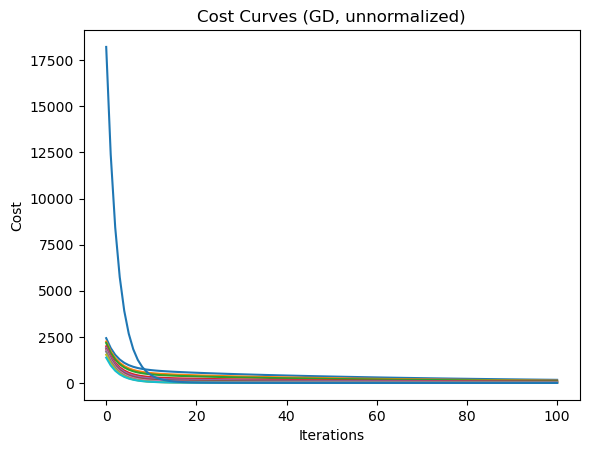

GD
Best initialization weights for unnormalized data:
 [[ 0. ]
 [ 2.5]
 [ 0. ]
 [-5. ]
 [-5. ]]


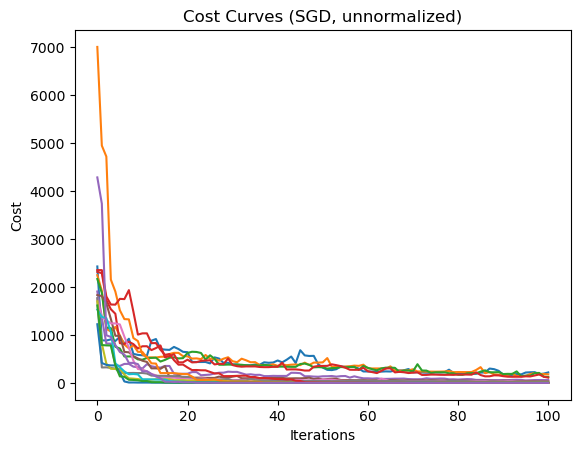

SGD
Best initialization weights for unnormalized data:
 [[2.5]
 [2.5]
 [0. ]
 [5. ]
 [5. ]]
==============GD================
RMSE for unnormalized training: 0.03836368425410957
==============SGD===============
RMSE for unnormalized training: 0.0763209658671403


In [16]:
from polynomialRegression import gradientDescent, SGD

max_iterations = 100
# Find the best initialization weights for the unnormalized data GD:
lr = 9e-4
w = findOptimumInitWeights(-5, 5, x_train, y_train, lr, max_iterations, gradientDescent, sensitivity=2.5)
plotCostCurves("Cost Curves (GD, unnormalized)") 
print("GD")
print("Best initialization weights for unnormalized data:\n", w)
model_unnormalized = gradientDescent(x_train, y_train, w, lr, max_iterations)
model_unnormalized.fit(lr, max_iterations)

y_unnorm_predict = model_unnormalized.predict(x_test)
RMSE_GD_UNNORM = np.sqrt(np.sum(np.square(y_test - y_unnorm_predict)))/y_test.shape[0]


# Find the best initialization weights for the unnormalized data SGD:
w = findOptimumInitWeights(-5, 5, x_train, y_train, lr, max_iterations, SGD, sensitivity=2.5)
plotCostCurves("Cost Curves (SGD, unnormalized)") 
print("SGD")
print("Best initialization weights for unnormalized data:\n", w)
model_unnormalized = SGD(x_train, y_train, w, lr, max_iterations)
model_unnormalized.fit(lr, max_iterations)

y_unnorm_predict = model_unnormalized.predict(x_test)
RMSE_SGD_UNNORM = np.sqrt(np.sum(np.square(y_test - y_unnorm_predict)))/y_test.shape[0]


# Print errors
print("==============GD================")
print("RMSE for unnormalized training:", RMSE_GD_UNNORM)

print("==============SGD===============")
print("RMSE for unnormalized training:", RMSE_SGD_UNNORM)

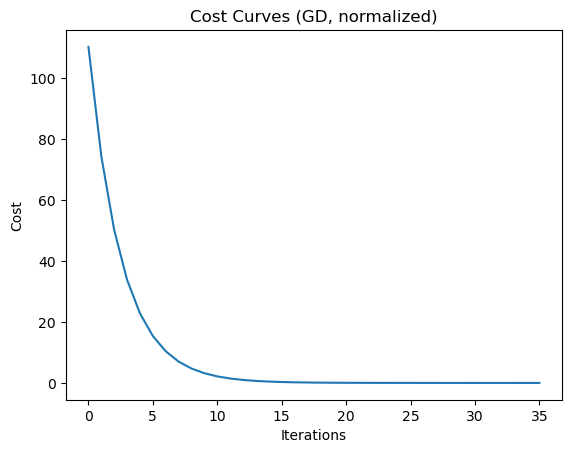

GD
Best initialization weights for normalized data:  [[-5.]
 [-5.]
 [-5.]
 [ 0.]
 [ 0.]]


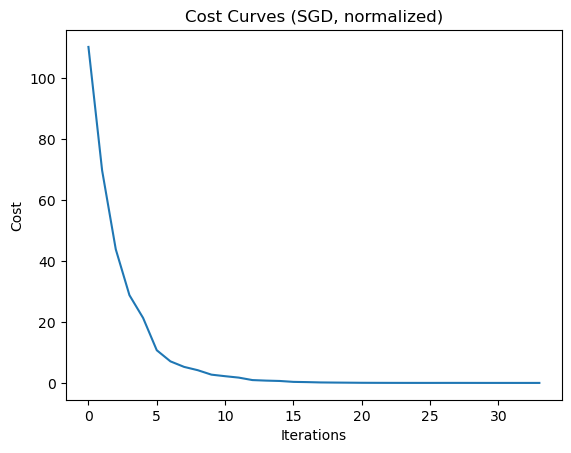

SGD
Best initialization weights for normalized data:
 [[-5.]
 [-5.]
 [-5.]
 [ 0.]
 [ 0.]]
==============GD================
RMSE for normalized training: 0.35023051125307725
==============SGD===============
RMSE for normalized training: 0.5413643291600893


In [17]:
##############################################################################
# TODO: Do all your normalized trainings with Gradient Descent and           #
# Stochastic Gradient Descent here.                                          #
# Plot all training cost history for different different                     #
# initial weights.                                                           #
# Test your models trained with GD and SGD by regressing on the test data.   #
# Report the test performance in terms of RMSE.                              #
# Compare the normalized and unnormalized training and testing results.      #
##############################################################################
from polynomialRegression import gradientDescent, SGD

max_iterations = 100

# Find the best initialization weights for the normalized data GD:
lr = 1e-1
w = findOptimumInitWeights(-5, 5, x_train_scaled, y_train_scaled, lr, max_iterations, gradientDescent, sensitivity=2.5)
plotCostCurves("Cost Curves (GD, normalized)") 
print("GD")
print("Best initialization weights for normalized data: ", w)
model_normalized = gradientDescent(x_train_scaled, y_train_scaled, w, lr, max_iterations)
model_normalized.fit(lr, max_iterations)

y_norm_predict = model_normalized.predict(x_test_scaled)
y_norm_inv = scaler_y.inverse_transform(y_norm_predict)
RMSE_GD_NORM = np.sqrt(np.sum(np.square(y_test - y_norm_inv)))/y_test.shape[0]

# Find the best initialization weights for the normalized data SGD:
w = findOptimumInitWeights(-5, 5, x_train_scaled, y_train_scaled, lr, max_iterations, SGD, sensitivity=2.5)
plotCostCurves("Cost Curves (SGD, normalized)") 
print("SGD")
print("Best initialization weights for normalized data:\n", w)
model_normalized = SGD(x_train_scaled, y_train_scaled, w, lr, max_iterations)
model_normalized.fit(lr, max_iterations)

y_norm_predict = model_normalized.predict(x_test_scaled)
y_norm_inv = scaler_y.inverse_transform(y_norm_predict)
RMSE_SGD_NORM = np.sqrt(np.sum(np.square(y_test - y_norm_inv)))/y_test.shape[0]

# Print errors
print("==============GD================")
print("RMSE for normalized training:", RMSE_GD_NORM)

print("==============SGD===============")
print("RMSE for normalized training:", RMSE_SGD_NORM)

## 2.1 CROSS-VALIDATION and Feature Selection for Linear Regression

In most of the real world datasets, training error do not reflect the actual test error. A widely-used practical method of obtaining a good estimate of the error rate of a learning
algorithm is **k-fold cross-validation** (Cross-Validation: CV). CV partitions the dataset into k equal-sized folds.
Each fold acts as a test set for evaluating the model being learned on the other k − 1 folds. The average
error across the k hypotheses is used as an estimate of the error rate. The final performance metric is typically the average of the performance metrics obtained in each iteration. Cross-validation provides a robust estimate of a model's performance and guards against overfitting. 

In this question you are expected to implement **cross-validate()** of the **gradientDescent()** class, under **LinearRegression** module. This method needs to implement 5 Fold cross-validation on the training set and return to average mean squared error on the validation sets using gradient descent training with mean squared cost. After that, you are expected to run the following cells and select the two features yielding the best estimate. Plot the cross validation performance of each combination. You need to check 6 scenarios, since $C(4,2) = 6$. After determining the two features, train a linear regression model on your entire training set using gradient descent, and test it on the test data. Plot the cost, and report the testing RMSE of your trained model.

**You may set learning rate to 0.5 .**

You may start by loading the data.

In [18]:
import numpy as np

with open('Q2_1.npy', 'rb') as f:
    x_train = np.load(f)
    x_test = np.load(f)
    y_train = np.load(f)
    y_test = np.load(f)


Normalize the data in the following cell. 

In [19]:
from data_utils import MinMaxScaler
# Create an instance of MinMaxScaler
scaler = MinMaxScaler(x_train)


# Transform x_train and x_test
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)


# Do the same for target variables
scaler_y = MinMaxScaler(y_train)


# Transform x_train and x_test
y_train_scaled = scaler_y.transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [20]:
import matplotlib.pyplot as plt

def getCost(model):
    return model.cost_history[-1]

def plotCostCurves(title):
    plt.xlabel('Iterations')
    plt.ylabel('Cost')
    plt.title(title)
    plt.show()

def _findOptimumInitWeightsDetailed(ranges_matrix, x_train, y_train, lr, max_iterations, model, plot=False):
    # find the best initialization for the weights by trying different initializations
    # the range for initializations is given by min and max
    # return the best initialization and the cost history

    if(not callable(model)):
        raise ValueError("model must be a callable function or class")

    best_cost = float('inf')
    best_weights = None
    
    
    # Iterate through all possible combinations of weight values
    for w1 in ranges_matrix[:, 0]:
        for w2 in ranges_matrix[:, 1]:
            for w3 in ranges_matrix[:, 2]:
                weights = np.array([[w1], [w2], [w3]])
                
                # Train the model with the current set of weights
                model_instance = model(x_train, y_train, weights, lr, max_iterations)
                model_instance.fit(lr, max_iterations)
                
                # Evaluate the performance of the model
                cost = getCost(model_instance)
                
                # Update the best weights if the current set of weights performs better
                if cost < best_cost:
                    best_cost = cost
                    best_weights = weights
                    if plot:
                        plt.plot(model_instance.cost_history, label=weights)

    return best_weights, best_cost

def findOptimumInitWeights(min, max, x_train, y_train, lr, max_iterations, model, sensitivity=250, plot=False):
    # find the best initialization for the weights by trying different initializations
    # the range for initializations is given by min and max
    # return the best initialization

    if(not callable(model)):
        raise ValueError("model must be a callable function or class")

    best_cost = float('inf')
    best_weights = None
    
    # Define the grid of possible values for each weight parameter
    weight_range = np.linspace(min, max, int((max - min) / sensitivity) + 1)
    
    # Iterate through all possible combinations of weight values
    for w1 in weight_range:
        for w2 in weight_range:
            for w3 in weight_range:
                weights = np.array([[w1], [w2], [w3]])
                
                # Train the model with the current set of weights
                model_instance = model(x_train, y_train, weights, lr, max_iterations)
                model_instance.fit(lr, max_iterations)
                
                # Evaluate the performance of the model
                cost = getCost(model_instance)
                
                # Update the best weights if the current set of weights performs better
                if cost < best_cost:
                    best_cost = cost
                    best_weights = weights
                    
    w0_min = int(best_weights[0] - (max - min) / sensitivity)
    w0_max = int(best_weights[0] + (max - min) / sensitivity)
    w0_range = np.linspace(w0_min, w0_max, w0_max-w0_min)

    w1_min = int(best_weights[1] - (max - min) / sensitivity)
    w1_max = int(best_weights[1] + (max - min) / sensitivity)
    w1_range = np.linspace(w1_min, w1_max, w1_max-w1_min)

    w2_min = int(best_weights[2] - (max - min) / sensitivity)
    w2_max = int(best_weights[2] + (max - min) / sensitivity)
    w2_range = np.linspace(w2_min, w2_max, w2_max-w2_min)
    
    # Create a single 2D matrix containing all ranges
    ranges_matrix = np.stack((w0_range, w1_range, w2_range), axis=-1)

    return _findOptimumInitWeightsDetailed(ranges_matrix, x_train, y_train, lr, max_iterations, model, plot)


def _findOptimumLRDetailed(lr_range, x_train, y_train, weights, max_iterations, model):
    if(not callable(model)):
        raise ValueError("model must be a callable function or class")

    best_cost = float('inf')
    best_lr = None
    
    
    # Iterate through all possible combinations of weight values
    for lr in lr_range:
        # Train the model with the current set of weights
        model_instance = model(x_train, y_train, weights, lr, max_iterations)
        model_instance.fit(lr, max_iterations)
        
        # Evaluate the performance of the model
        cost = getCost(model_instance)
        
        # Update the best weights if the current set of weights performs better
        if cost < best_cost:
            best_cost = cost
            best_lr = lr

    return best_lr, best_cost

def findOptimumLR(min, iters, x_train, y_train, weights, max_iterations, model, sensitivity=10):
    if(not callable(model)):
        raise ValueError("model must be a callable function or class")

    best_cost = float('inf')
    best_lr = None
    
    # Define the grid of possible values for each weight parameter
    lr_range = [min]
    for _ in range(iters):
        lr_range.append(sensitivity * lr_range[-1])
        
    # Iterate through all possible combinations of weight values
    for lr in lr_range:
        # Train the model with the current set of weights
        model_instance = model(x_train, y_train, weights, lr, max_iterations)
        model_instance.fit(lr, max_iterations)
        
        # Evaluate the performance of the model
        cost = getCost(model_instance)
        
        # Update the best weights if the current set of weights performs better
        if cost < best_cost:
            best_cost = cost
            best_lr = lr
    lr_range = [best_lr]
    sensitivity = np.log(sensitivity)
    for _ in range(iters // 2):
        lr_range.insert(0, lr_range[0] / sensitivity)
    for _ in range(iters // 2):
        lr_range.append(lr_range[-1] * sensitivity)

    return _findOptimumLRDetailed(lr_range, x_train, y_train, weights, max_iterations, model)

You may do the rest of the tasks here.

best lr:  0.20226859844834322
the cost:  0.004816039246246242
best weights:
 [[2.        ]
 [0.66666667]
 [2.        ]]
the cost:  0.014809815690219453
Indices: 0 1
Cross-Validation Error: 2.4830578707487097

best weights:
 [[2.        ]
 [0.66666667]
 [2.        ]]
the cost:  0.028297431443456693
Indices: 0 2
Cross-Validation Error: 3.4383533898381

best weights:
 [[2.        ]
 [0.66666667]
 [2.        ]]
the cost:  0.03060762392494358
Indices: 0 3
Cross-Validation Error: 3.5779905195349206

best weights:
 [[-2.        ]
 [-0.66666667]
 [-0.66666667]]
the cost:  0.007744195167826846
Indices: 1 2
Cross-Validation Error: 1.796948916590256

best weights:
 [[0.66666667]
 [0.66666667]
 [0.66666667]]
the cost:  0.010948427574050458
Indices: 1 3
Cross-Validation Error: 2.137475859985984

best weights:
 [[0.66666667]
 [0.66666667]
 [0.66666667]]
the cost:  0.022782393098179834
Indices: 2 3
Cross-Validation Error: 3.0890744668616406

The Best Features


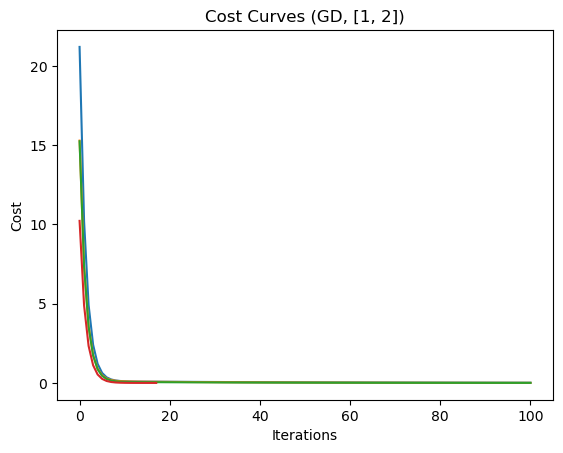

best weights:
 [[-2.        ]
 [-0.66666667]
 [-0.66666667]]
the cost:  0.007744195167826846
==============GD================
RMSE for normalized training:  0.03994770767337101


In [21]:
##############################################################################
# TODO: Implement cross-validation under the LinearRegression.py as          #
# as instructed. (Using GD, 5-Fold., Implement hyperparameter search inside) #
# Implement feature selection using cross-validation. Pick the two feature   #
# dimensions yielding the best validation performance.                       #
# Using these dimensions, train a linear regression model with GD and        #
# Plot all training cost history for different different                     #
# initial weights.                                                           #
# Report the test performance in terms of RMSE.                              #
##############################################################################

from linearRegression import gradientDescent

max_iterations = 100
# Create your training input matrix. Modify the following code as you wish if necessary.
x = x_train_scaled
y = y_train_scaled.reshape((-1, 1))

n_features = x.shape[1]

lr, cl = findOptimumLR(1e-6, 10, x, y, np.zeros((n_features+1, 1)), max_iterations, gradientDescent, sensitivity=10**0.5)
print("best lr: ", lr)
print("the cost: ", cl)

min_val_err = float("inf")
min_feat = None
# Perform cross-validation for all combinations of two features
for i in range(n_features):
    for j in range(i + 1, n_features):
        # Select two features based on indices i and j
        selected_features = x[:, [i, j]]
        w, c = findOptimumInitWeights(-10, 10, selected_features, y, lr, max_iterations, gradientDescent, sensitivity=10, plot=False)
        print("best weights:\n", w)
        print("the cost: ", c)
        model = gradientDescent(selected_features, y, w, lr, max_iterations)
        model.fit()

        # Perform 5-fold cross-validation. "model" refers to your gradientDescent object. 
        cross_val_error = model.cross_validate(k=5)
        if cross_val_error < min_val_err:
            min_val_err = cross_val_error
            min_feat = [i, j]

        # Print indices and cross-validation results
        print("Indices:", i, j)
        print("Cross-Validation Error:", cross_val_error)
        print()

print("The Best Features")
selected_features = x[:, min_feat]
w, c = findOptimumInitWeights(-10, 10, selected_features, y, lr, max_iterations, gradientDescent, sensitivity=10, plot=True)
plotCostCurves("Cost Curves (GD, " + str(min_feat) + ")") 
print("best weights:\n", w)
print("the cost: ", c)
model = gradientDescent(selected_features, y, w, lr, max_iterations)
model.fit()

y_test = y_test.reshape((-1, 1))
x_predict = x_test_scaled[:, min_feat]
y_norm_predict = model.predict(np.c_[np.ones((x_predict.shape[0], 1)), x_predict])
y_norm_inv = scaler_y.inverse_transform(y_norm_predict)
RMSE_GD_NORM = np.sqrt(np.sum(np.square(y_test - y_norm_inv)))/y_test.shape[0]
print("==============GD================")
print("RMSE for normalized training: ", RMSE_GD_NORM)

## 2.2 CROSS-VALIDATION and Feature Selection for Linear Regression (by Stochastic Gradient Descent)

In this question you are expected to implement **cross-validate()** of the **SGD()** class, under **linearRegression.py** module. This method needs to implement 5 Fold cross-validation on the training set and return to average mean squared error on the validation sets using stochastic gradient descent training with mean squared cost. Normalize your data, create the corresponding linear regression input matrices and implement feature selection procedure as before. Plot the cross validation performance of each combination. You need to check 6 scenarios, since $C(4,2) = 6$. After determining the two features, train a linear regression model on your entire training set using gradient descent, and test it on the test data. Plot the cost, and report the testing RMSE of your trained model.

best lr:  0.10000000000000005
the cost:  0.010513338671604951
best weights:
 [[0.66666667]
 [0.66666667]
 [0.66666667]]
the cost:  0.015533679524128522
Indices: 0 1
Cross-Validation Error: 2.6881364665707728

best weights:
 [[0.66666667]
 [0.66666667]
 [0.66666667]]
the cost:  0.031219820145721975
Indices: 0 2
Cross-Validation Error: 3.571064466365015

best weights:
 [[-2.        ]
 [-0.66666667]
 [-0.66666667]]
the cost:  0.030096299276563904
Indices: 0 3
Cross-Validation Error: 3.747417640865207

best weights:
 [[-2.        ]
 [-0.66666667]
 [-0.66666667]]
the cost:  0.0070503228260890855
Indices: 1 2
Cross-Validation Error: 2.3576543732390682

best weights:
 [[0.66666667]
 [0.66666667]
 [0.66666667]]
the cost:  0.010452935448096154
Indices: 1 3
Cross-Validation Error: 2.304958616391297

best weights:
 [[0.66666667]
 [0.66666667]
 [0.66666667]]
the cost:  0.022495645804616077
Indices: 2 3
Cross-Validation Error: 3.0854330208103207

The Best Features


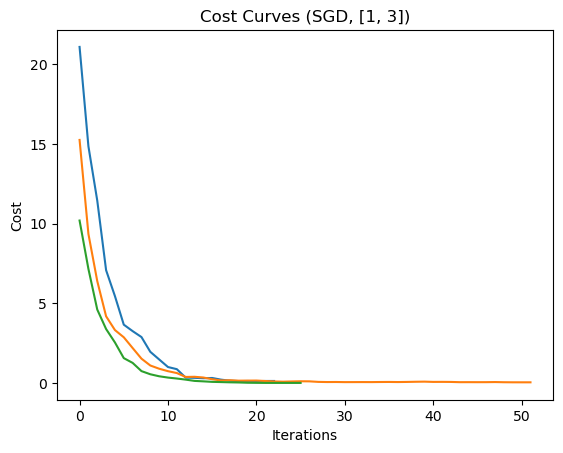

best weights:
 [[-2.        ]
 [-0.66666667]
 [-0.66666667]]
the cost:  0.010414193828546364
==============SGD================
RMSE for normalized training:  0.05063040805706231


In [22]:
##############################################################################
# TODO: Implement cross-validation under the LinearRegression.py as          #
# as instructed. (Using GD, 5-Fold., Implement hyperparameter search inside) #
# Implement feature selection using cross-validation. Pick the two feature   #
# dimensions yielding the best validation performance.                       #
# Using only these dimensions, train a linear regression model with GD and   #
# Plot all training cost history for different different                     #
# initial weights.                                                           #
# Report the test performance in terms of RMSE.                              #
##############################################################################

from linearRegression import SGD

max_iterations = 100

x = x_train_scaled
y = y_train_scaled.reshape((-1, 1))

n_features = x.shape[1]

lr, cl = findOptimumLR(1e-6, 10, x, y, np.zeros((n_features+1, 1)), max_iterations, SGD, sensitivity=10**0.5)
print("best lr: ", lr)
print("the cost: ", cl)

min_val_err = float("inf")
min_feat = None

# Perform cross-validation for all combinations of two features
for i in range(n_features):
    for j in range(i + 1, n_features):
        # Select two features based on indices i and j
        selected_features = x[:, [i, j]]
        w, c = findOptimumInitWeights(-10, 10, selected_features, y, lr, max_iterations, SGD, sensitivity=10, plot=False)
        print("best weights:\n", w)
        print("the cost: ", c)
        model = SGD(selected_features, y, w, lr, max_iterations)
        model.fit()

        # Perform 5-fold cross-validation. "model" refers to your gradientDescent object. 
        cross_val_error = model.cross_validate(k=5)
        if cross_val_error < min_val_err:
            min_val_err = cross_val_error
            min_feat = [i, j]

        # Print indices and cross-validation results
        print("Indices:", i, j)
        print("Cross-Validation Error:", cross_val_error)
        print()

print("The Best Features")
selected_features = x[:, min_feat]
w, c = findOptimumInitWeights(-10, 10, selected_features, y, lr, max_iterations, SGD, sensitivity=10, plot=True)
plotCostCurves("Cost Curves (SGD, " + str(min_feat) + ")")
print("best weights:\n", w)
print("the cost: ", c)
model = SGD(selected_features, y, w, lr, max_iterations)
model.fit()

y_test = y_test.reshape((-1, 1))
x_predict = x_test_scaled[:, min_feat]
y_norm_predict = model.predict(np.c_[np.ones((x_predict.shape[0], 1)), x_predict])
y_norm_inv = scaler_y.inverse_transform(y_norm_predict)
RMSE_SGD_NORM = np.sqrt(np.sum(np.square(y_test - y_norm_inv)))/y_test.shape[0]
print("==============SGD================")
print("RMSE for normalized training: ", RMSE_SGD_NORM)






### Compare the results of Question 2.1 and 2.2 and comment on them. 

Best features for both GD (gradient descent) and SGD (stochastic gradient descent) are features at indices 1 and 2 (0-indexed).
This is expected because we are finding out which 2 features represent the data most using CV (cross-validation). Our method of fitting a line does not affect to feature's effect on y value.

Best LR (learning rate) is 0.2022 for both. This is because we used 0 vector for initial weight while calculating the best LR.

However best initial weights for GD and SGD are different.

| weights | GD | SGD |
|------|:-:|:---------:|
| w0 | -1.90909091 | -2.63636364 |
| w1 | -0.72727273 | -0.54545455 |
| w2 | -0.72727273 | -1.63636364 |

As it can be expected, cost and RMSE is much lower for GD compared to the SGD.

|  | GD | SGD |
|------|:-:|:---------:|
| Cost | 0.0077 | 0.0103 |
| RMSE | 0.0394 | 0.0578 |

Cross validation allows us to boost our model's performance by reducing the feature count with expense of accuracy of model. Reducing feature count means, we can do more comprehensive hyperparameter search and while fitting a curve or a line, there will be less calculations. 
